In [ ]:
!pip install catboost
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
SEED=55555

from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.cluster import KMeans

from xgboost import XGBClassifier,XGBRegressor
from lightgbm import LGBMClassifier,LGBMRegressor

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from xgboost import plot_importance
import cufflinks as cf
import plotly.offline

from catboost import CatBoostClassifier,Pool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.3 MB/s eta 0:00:00


In [ ]:
train_values = pd.read_csv('sample_data/train_values.csv',index_col='building_id')
test_values = pd.read_csv('sample_data/test_values.csv',index_col='building_id')
train_labels = pd.read_csv('sample_data/train_labels.csv',index_col='building_id')

In [ ]:
train_values.info()
train_values[['geo_level_1_id','geo_level_2_id','geo_level_3_id']] = \
train_values[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].astype(str)
test_values[['geo_level_1_id','geo_level_2_id','geo_level_3_id']] = \
test_values[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].astype(str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

In [ ]:
cat_cols=['geo_level_1_id','geo_level_2_id','geo_level_3_id','land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status','count_floors_pre_eq', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other']

In [ ]:
#train_values['age_995'] = (train_values.age > 200).astype(int)
#test_values['age_995'] = (test_values.age > 200).astype(int)

In [ ]:
train_values.columns

Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
     

In [ ]:
'''
num_cols = [
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage', 
 'count_families']
for c ,d in zip(train_values.columns,train_values.dtypes):
    if c in num_cols:
        #f_dta4[c] = StandardScaler().fit_transform(f_dta4[[c]].to_numpy()).flatten()
        scaler = StandardScaler().fit(train_values[[c]])
        train_values[c] = scaler.transform(train_values[[c]]).astype(int)
        
    else:
        print(c,' not process.')

for c ,d in zip(test_values.columns,test_values.dtypes):
    if c in num_cols:
        #f_dta4[c] = StandardScaler().fit_transform(f_dta4[[c]].to_numpy()).flatten()
        scaler = StandardScaler().fit(test_values[[c]])
        test_values[c] = scaler.transform(test_values[[c]]).astype(int)
        
    else:
        print(c,' not process.')
        '''

"\nnum_cols = [\n 'count_floors_pre_eq',\n 'age',\n 'area_percentage',\n 'height_percentage', \n 'count_families']\nfor c ,d in zip(train_values.columns,train_values.dtypes):\n    if c in num_cols:\n        #f_dta4[c] = StandardScaler().fit_transform(f_dta4[[c]].to_numpy()).flatten()\n        scaler = StandardScaler().fit(train_values[[c]])\n        train_values[c] = scaler.transform(train_values[[c]]).astype(int)\n        \n    else:\n        print(c,' not process.')\n\nfor c ,d in zip(test_values.columns,test_values.dtypes):\n    if c in num_cols:\n        #f_dta4[c] = StandardScaler().fit_transform(f_dta4[[c]].to_numpy()).flatten()\n        scaler = StandardScaler().fit(test_values[[c]])\n        test_values[c] = scaler.transform(test_values[[c]]).astype(int)\n        \n    else:\n        print(c,' not process.')\n        "

In [ ]:
'''
print(format('How to find optimal parameters for CatBoost using GridSearchCV for Classification','*^82'))   
# Split the training data set
X = train_values; y = train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print('Data loaded')

#Initialise the catboost classifier, if you have no GPU on your machine you can remove task_type="GPU" 
model = CatBoostClassifier(eval_metric='TotalF1', task_type="GPU",cat_features=cat_cols)

#Choose parameters to test here
parameters = {'depth':[2,4],
            'iterations':[2000],
            'learning_rate':[0.05], 
            'l2_leaf_reg':[3,5,7,9],
            'border_count':[11,17]}
print('Paramaters defined')

#Initialise the Gridsearch, cv is set to 2 for speed.
randm = GridSearchCV(estimator=model, param_grid = parameters,cv = 2)
randm.fit(X_train, y_train)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)

print("\n The best score across ALL searched params:\n",
      randm.best_score_)

print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)

print("\n ========================================================")
'''

'\nprint(format(\'How to find optimal parameters for CatBoost using GridSearchCV for Classification\',\'*^82\'))   \n# Split the training data set\nX = train_values; y = train_labels\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)\nprint(\'Data loaded\')\n\n#Initialise the catboost classifier, if you have no GPU on your machine you can remove task_type="GPU" \nmodel = CatBoostClassifier(eval_metric=\'TotalF1\', task_type="GPU",cat_features=cat_cols)\n\n#Choose parameters to test here\nparameters = {\'depth\':[2,4],\n            \'iterations\':[2000],\n            \'learning_rate\':[0.05], \n            \'l2_leaf_reg\':[3,5,7,9],\n            \'border_count\':[11,17]}\nprint(\'Paramaters defined\')\n\n#Initialise the Gridsearch, cv is set to 2 for speed.\nrandm = GridSearchCV(estimator=model, param_grid = parameters,cv = 2)\nrandm.fit(X_train, y_train)\n\n# Results from Random Search\nprint("\n========================================================")\nprint("

In [ ]:
from sklearn.metrics import f1_score
from scipy.stats.mstats import winsorize

#params = {'depth':4,
            #'iterations':[2000],
            #'learning_rate':[0.05], 
            #'l2_leaf_reg':[7],
#            'border_count':13}
cat_f = [0,1,2,4,7,8,9,10,11,12,13,25]

print("Resample the train test split & try these parameters set")
X = train_values; y = train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

tr = Pool(data=X_train, label=y_train,cat_features=cat_f)
ev = Pool(data=X_test, label=y_test,cat_features=cat_f)
#input best params here from randm.best_params_
model = CatBoostClassifier(border_count=11,l2_leaf_reg=1,depth=9,iterations=1000,learning_rate=0.06,od_pval = 10**(-4),eval_metric='TotalF1', verbose=True, task_type="GPU",loss_function='MultiClass')
#model = CatBoostClassifier(l2_leaf_reg=1,depth=9,iterations=1000,learning_rate=0.06,od_pval = 10**(-4),eval_metric='TotalF1', silent=True, task_type="GPU",cat_features=cat_cols)
#model = CatBoostClassifier(use_best_model=True,l2_leaf_reg=2,depth=7,iterations=2000,eval_metric='TotalF1',random_seed=42, silent=True, task_type="GPU",cat_features=cat_cols)
#model.fit(X_train, y_train)
model.fit(tr)
#X_test["age"] = winsorize(X_test["age"],(0, 0.04))
#X_test["area_percentage"] = winsorize(X_test["area_percentage"],(0, 0.05))
#X_test["height_percentage"] = winsorize(X_test["height_percentage"],(0, 0.05))


preds=model.predict(X_test)

#f1 score is the metric used in the competition
accuracy=f1_score(y_test,preds,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy)
print('\n Benchmark model was: 0.5815')

Resample the train test split & try these parameters set
0:	learn: 0.6900147	total: 113ms	remaining: 1m 52s
1:	learn: 0.6907120	total: 232ms	remaining: 1m 55s
2:	learn: 0.6919956	total: 346ms	remaining: 1m 55s
3:	learn: 0.6907962	total: 453ms	remaining: 1m 52s
4:	learn: 0.6910971	total: 572ms	remaining: 1m 53s
5:	learn: 0.6912799	total: 679ms	remaining: 1m 52s
6:	learn: 0.6911056	total: 795ms	remaining: 1m 52s
7:	learn: 0.6917154	total: 907ms	remaining: 1m 52s
8:	learn: 0.6917595	total: 1.02s	remaining: 1m 52s
9:	learn: 0.6919132	total: 1.13s	remaining: 1m 52s
10:	learn: 0.6924435	total: 1.25s	remaining: 1m 51s
11:	learn: 0.6924897	total: 1.35s	remaining: 1m 51s
12:	learn: 0.6931564	total: 1.48s	remaining: 1m 52s
13:	learn: 0.6935263	total: 1.56s	remaining: 1m 49s
14:	learn: 0.6945070	total: 1.61s	remaining: 1m 46s
15:	learn: 0.6945284	total: 1.67s	remaining: 1m 42s
16:	learn: 0.6946644	total: 1.73s	remaining: 1m 39s
17:	learn: 0.6948881	total: 1.76s	remaining: 1m 36s
18:	learn: 0.6949

In [ ]:
test_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86868 entries, 300051 to 501372
Data columns (total 38 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   geo_level_1_id                          86868 non-null  object
 1   geo_level_2_id                          86868 non-null  object
 2   geo_level_3_id                          86868 non-null  object
 3   count_floors_pre_eq                     86868 non-null  int64 
 4   age                                     86868 non-null  int64 
 5   area_percentage                         86868 non-null  int64 
 6   height_percentage                       86868 non-null  int64 
 7   land_surface_condition                  86868 non-null  object
 8   foundation_type                         86868 non-null  object
 9   roof_type                               86868 non-null  object
 10  ground_floor_type                       86868 non-null  object
 

In [ ]:
predictions = model.predict(test_values)
submission_format = pd.read_csv('sample_data/submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission['damage_grade'] =my_submission['damage_grade'].astype(int)
my_submission.to_csv('submission_cat8.csv')

In [ ]:
one_hot_col=['land_surface_condition',
         'foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration', 'legal_ownership_status']
print("Resample the train test split & try these parameters set")



X = train_values; y = train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

for c in X_train.columns:
  if c in one_hot_col:
    X_train = pd.concat([X_train,pd.get_dummies(X_train[[c]])],axis=1)
    X_train.drop(columns=[c],inplace=True)
 
for c in X_test.columns:
   if c in one_hot_col:
      X_test = pd.concat([X_test,pd.get_dummies(X_test[[c]])],axis=1)
      X_test.drop(columns=[c],inplace=True)

Resample the train test split & try these parameters set


<Axes: >

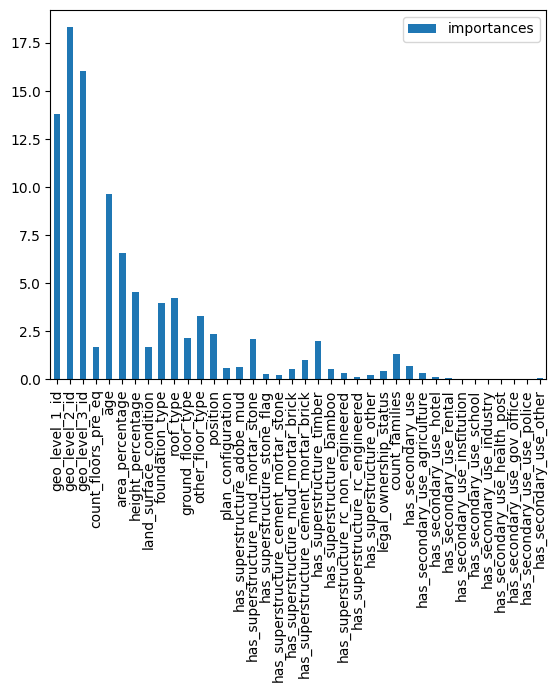

In [ ]:
df_importances=pd.DataFrame(model.feature_importances_)
df_importances.index=train_values.columns
df_importances.columns=['importances']
df_importances.plot.bar()

In [ ]:

'''   
params = {
    "learning_rate": 0.01, 
    "verbose": 100, 
    "random_state": 2020, 
    "metric": "average_precision", 
    "verbose": -1,
    "boosting_type": "dart",
    "num_leaves": 20,
    "num_iterations": 200,
}


#input best params here from randm.best_params_
model = LGBMClassifier(**params)
model.fit(X_train, y_train)
#model.fit(X, y)
#X_test["age"] = winsorize(X_test["age"],(0, 0.04))
#X_test["area_percentage"] = winsorize(X_test["area_percentage"],(0, 0.05))
#X_test["height_percentage"] = winsorize(X_test["height_percentage"],(0, 0.05))


preds=model.predict(X_test)

#f1 score is the metric used in the competition
accuracy=f1_score(y_test,preds,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy)
print('\n Benchmark model was: 0.5815')
'''

In [ ]:
'''
predictions = model.predict(test_values)
submission_format = pd.read_csv('sample_data/submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission['damage_grade'] =my_submission['damage_grade'].astype(int)
my_submission.to_csv('submission_LGM1.csv')
'''